# Exploring building reference datasets with kerchunk

The idea: build a test intake catalogue of kerchunk virtual dataset(s) from the COSIMA output(s) and see how it performs

In [1]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/kerchunk_025deg_jra55_iaf_omip2

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/kerchunk_025deg_jra55_iaf_omip2


In [2]:
import re
import os
import time
import glob
import datetime

import pandas as pd

import xarray as xr

import fsspec.implementations.reference

In [3]:
import sys
sys.path.insert(1, "/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake")
from kerchunk_utils import create_reference

# Build a reference dataset for all cycles of `access-om2-025` `025deg_jra55_iaf_omip2` 

**25 TB** of compressed data across **11,385 netcdf4 files** is referenced by **6 parquet files** totalling **884 MB**

I ran these cells with a full broadwell node

## Prepare combined kerchunk reference json

Note I found a bug in `kerchunk.combine.auto_dask`. My fix has now been merged, but I still have issues using `auto_dask` for datasets of this size - workers die and data doesn't get written. Here we'll do things manually.

Note also, the `ocean_budget` files are annual for cycles 1-5 and monthly for cycle 6 - ignore for now. In the long run, we should add checks that input files are consistent (frequency, variables...)

In [4]:
fs = fsspec.filesystem('file')
exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle*"

def get_cycle(index, fs, var, fn):
    return int(re.search(r"cycle(\d+)", fn)[1])

to_kerchunk = {
    # "ocean_month": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_month.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "xt_ocean", 
    #             "yt_ocean", 
    #             "st_ocean", 
    #             "xu_ocean", 
    #             "yu_ocean", 
    #             "sw_ocean", 
    #             "grid_xt_ocean", 
    #             "grid_yt_ocean", 
    #             "grid_xu_ocean", 
    #             "grid_yu_ocean", 
    #             "potrho", 
    #             "neutral",
    #             "neutralrho_edges",
    #             "nv",
    #             "potrho",
    #             "potrho_edges",
    #             "st_edges_ocean",
    #             "sw_edges_ocean"
    #          ]
    #     )
    # ),

    # # "ocean_budget": (
    # #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_budget.nc")),
    # #     dict(
    # #         coo_map={"cycle": get_cycle},
    # #         concat_dims=["time", "cycle"],
    # #         identical_dims=[
    # #             "xt_ocean", 
    # #             "yt_ocean", 
    # #             "st_ocean", 
    # #             "xu_ocean", 
    # #             "yu_ocean", 
    # #             "nv",
    # #             "st_edges_ocean",
    # #          ]
    # #     )
    # # ),

    # "ocean_scalar": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_scalar.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=["scalar_axis", "nv"]
    #     )
    # ),

    # "ocean_daily": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_daily.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "xt_ocean", 
    #             "yt_ocean", 
    #             "xu_ocean", 
    #             "yu_ocean", 
    #             "nv",
    #          ]
    #     )
    # ),
    
    # "ice_month": (
    #     sorted(fs.glob(f"{exp_root}/output*/ice/OUTPUT/iceh.????-??.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "d2",
    #             "ni", 
    #             "nj", 
    #             "nc", 
    #             "nkice", 
    #             "nksnow",
    #             "nkbio",
    #             "nvertices",
    #          ]
    #     )
    # ),
    
    # "ice_daily": (
    #     sorted(fs.glob(f"{exp_root}/output*/ice/OUTPUT/iceh.????-??-daily.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "d2",
    #             "ni", 
    #             "nj", 
    #             "nc", 
    #          ]
    #     )
    # ),
}

In [5]:
for filename, single_input in to_kerchunk.items():
    print(f"Kerchunking {filename}...")
    tic = time.perf_counter()
    create_reference(
        single_input,
        filename=f"025deg_jra55_iaf_omip2/{filename}",
        cleanup="all"
    )
    toc = time.perf_counter()
    print(f"   Done in {str(datetime.timedelta(seconds=toc-tic))} (h:m:s)")

Kerchunking ocean_budget...
   Done in 0:09:59.223520 (h:m:s)


# Example compute on a reference datasets and compare to `open_mfdataset`

In [6]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

## 1. Reference parquet dataset

In [7]:
%%time

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "./025deg_jra55_iaf_omip2/ocean_daily.parq", lazy=True
).get_mapper()

ds = xr.open_dataset(
    m,
    engine="zarr",
    backend_kwargs={"consolidated": False},
    use_cftime=True,
    drop_variables=["average_T1", "average_T2"], # Need to work out what's wrong with these
    chunks="auto",
)

CPU times: user 13.4 s, sys: 2.21 s, total: 15.6 s
Wall time: 15.8 s


In [8]:
%%time

global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 9min 3s, sys: 1min 55s, total: 10min 58s
Wall time: 29min 10s


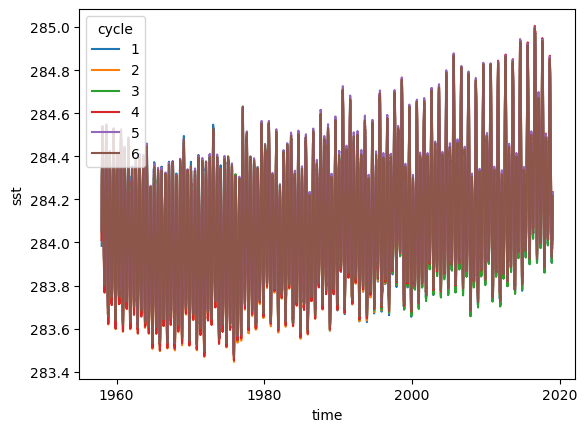

In [9]:
_ = global_mean.plot.line(x="time")

## 2. `open_mfdataset`

In [7]:
%%time

exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle?"

files = []
for cycle in sorted(glob.glob(exp_root)):
    files.append(sorted(glob.glob(f"{cycle}/output*/ocean/ocean_daily.nc")))

ds = []
for f in files:
    ds.append(
        xr.open_mfdataset(
            f,
            chunks={
                "cycle": 4,
                "time": 4,
                "yt_ocean": -1,
                "xt_ocean": -1
            }, # Same chunking as kerchunk reference dataset
            concat_dim="time",
            parallel=True,
            combine="nested",
            data_vars="minimal", 
            coords="minimal", 
            compat="override"
        )
    )
    
ds = xr.concat(ds, dim=pd.Index(range(len(files)), name="cycle"))

CPU times: user 26.9 s, sys: 3.68 s, total: 30.6 s
Wall time: 33.2 s


In [8]:
%%time

global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 9min 46s, sys: 1min 40s, total: 11min 26s
Wall time: 21min 27s


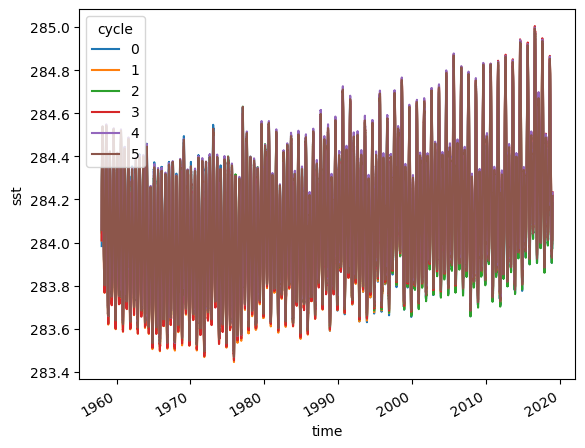

In [9]:
_ = global_mean.plot.line(x="time")

## Notes (some outdated)

- The main impediment to this sort of approach at the moment is that kerchunk references are stored as inefficient json files which can be very large for datasets comprising many chunks. Currently this entire file is loaded with `open_dataset` (and loaded onto each worker when using a distributed cluster) which can require lots of memory and overhead. This outweighs the benefits kerchunk provides in this application (consolidation + zarr simplicity/performance).

- This said, there are a number of things in the kerchunk pipeline that should address the above issue: 1) new data structures for the reference set(s) that facilitate lazy loading (see https://github.com/fsspec/kerchunk/issues/240 and https://github.com/fsspec/kerchunk/issues/134), 2) the ability the split/combine chunks within a reference file but this would have limitations (e.g. couldn't work for particular types of compression, see https://github.com/fsspec/kerchunk/issues/124 and https://github.com/fsspec/kerchunk/issues/134).

- The approach of generating reference datasets for new experiments should be relatively straight-forward if we can have some confidence that all input files will be readily "concatenatable" in the sense that they have the same chunking patterns, coordinates on fixed dims, fixed auxiliary coordinates, variables (where approapriate) etc. The latest functionality for combining references in kerchunk is pretty versatile, see https://fsspec.github.io/kerchunk/tutorial.html#using-coo-map.

- Where the raw data are unchunked (e.g. netcdf3), this approach can significantly impact performance since fsspec will make the full range request even for subsets (https://github.com/fsspec/kerchunk/issues/124).

In [10]:
client.close()

# Explore large parquet file

Why is `ocean_daily`, for example, so much slower to process?

In [1]:
import pandas as pd

In [2]:
ocean_daily_table = pd.read_parquet(
    "/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/025deg_jra55_iaf_omip2/ocean_daily.parq",
    engine="fastparquet",
)

In [3]:
len(ocean_daily_table)

84353252

In [6]:
ocean_budget_table = pd.read_parquet(
    "/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake/025deg_jra55_iaf_omip2/ocean_budget.parq",
    engine="auto",
)

ValueError: invalid literal for int() with base 10: '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle1/output000/ocean/ocean_budget.nc'

In [ ]:
len(ocean_month_table)